### Importing liberaries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector

In [2]:
conn=mysql.connector.connect(host="localhost", user="root", passwd="905005", database="Olst_E_Commerce")
cursor=conn.cursor()

In [3]:
query = """SHOW TABLES"""
cursor.execute(query)
result = cursor.fetchall()

# Print the list of tables
print("Tables in the database:")
for table in result:
    print(table[0]) 

Tables in the database:
category_name_translation
customers
geolocation
order_items
order_reviews
orders
payments
products
sellers


In [4]:
# Columns in product table.
cursor.execute("describe products")
result= cursor.fetchall()
for i in result:
    print(i[0])

product_id
product_category_name
product_weight_g
product_length_cm
product_height_cm
product_width_cm


## Customer Count by State

In [5]:
query="""select customer_state, count(*) as no_of_customers from customers group by customer_state
order by no_of_customers desc"""
cursor.execute(query)
result=cursor.fetchall()
df=pd.DataFrame(result, columns=["State","No_of_customers"])
df.head()


,State,No_of_customers
0,SP,41746
1,RJ,12852
2,MG,11635
3,RS,5466
4,PR,5045


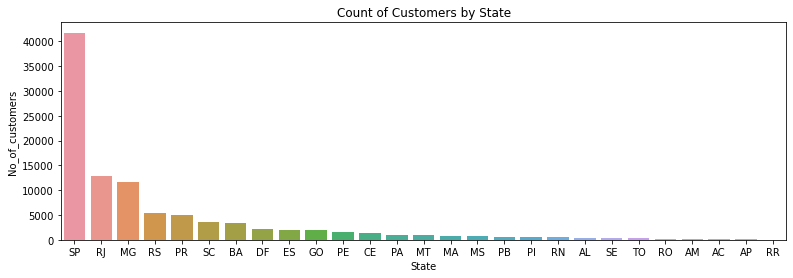

In [6]:
fig=plt.figure(figsize=(13,4))
sns.barplot(x="State",y="No_of_customers", data=df)
plt.title("Count of Customers by State")
plt.show()

## Count the number of orders placed per Year.

In [8]:
query= """select year(order_purchase_timestamp) as year, count(*) from orders group by year"""
cursor.execute(query)
result=cursor.fetchall()
df=pd.DataFrame(result, columns=["year","Order_placed"])
df


,year,Order_placed
0,2017,45101
1,2018,54011
2,2016,329


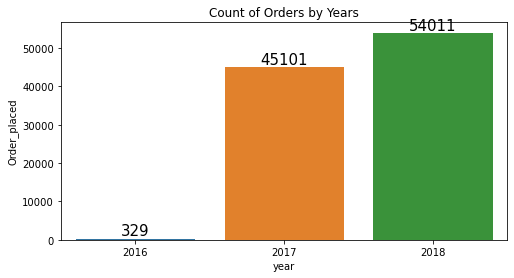

In [9]:
fig=plt.figure(figsize=(8,4))
ax=sns.barplot(x="year",y="Order_placed", data=df)
ax.bar_label(ax.containers[0],fontsize=15)
plt.title("Count of Orders by Years")
plt.show()

## Distinct payment type used for payment.

In [10]:
query= """select distinct payment_type from payments"""
cursor.execute(query)
result=cursor.fetchall()
df=pd.DataFrame(result, columns=["Payment_type"])
df

,Payment_type
0,credit_card
1,boleto
2,voucher
3,debit_card
4,not_defined


## Average Payment Value by Payment Type.

In [11]:
query= """select payment_type, avg(payment_value) from payments group by payment_type"""
cursor.execute(query)
result=cursor.fetchall()
df=pd.DataFrame(result, columns=["Payment_type","Average_Payment"])
df

,Payment_type,Average_Payment
0,credit_card,163.319021
1,boleto,145.034435
2,voucher,65.703354
3,debit_card,142.570170
4,not_defined,0.000000


## Average Delivery Time by State.

In [12]:
query= """select customers.customer_state, 
          avg(datediff(orders.order_delivered_customer_date, orders.order_purchase_timestamp))
          from orders join customers on orders.customer_id=customers.customer_id
          where orders.order_delivered_customer_date is not null
          group by customers.customer_state"""
cursor.execute(query)
result=cursor.fetchall()
df=pd.DataFrame(result, columns=["State","avg_del_time_days"])
df.head()

,State,avg_del_time_days
0,SP,8.7005
1,PR,11.9380
2,RS,15.2485
3,MG,11.9465
4,BA,19.2786


## Percentage of orders that were paid in installments.

In [13]:
query= """select sum(case when payment_installments>1 then 1 else 0 end)/count(*)*100 from payments"""
cursor.execute(query)
result=cursor.fetchall()
print("The percentage of orders that were paid in installments is: ",result[0][0])

The percentage of orders that were paid in installments is:  49.4176


## Find the total sales per category.

In [14]:
query= """select products.product_category_name, round(sum(payments.payment_value),2) as payment 
          from products join order_items on products.product_id=order_items.product_id
          join payments on payments.order_id=order_items.order_id group by product_category_name
          order by payment desc"""
cursor.execute(query)
result=cursor.fetchall()
df=pd.DataFrame(result, columns=["product_category","total_sale"])
df.head()

,product_category,total_sale
0,cama_mesa_banho,1712553.67
1,beleza_saude,1657373.12
2,informatica_acessorios,1585330.45
3,moveis_decoracao,1430176.39
4,relogios_presentes,1429216.68


## Total Revenue generated and orders count by States

In [15]:
query= """select c.customer_state, round(sum(oi.price+oi.freight_value),2) as total_revenue,
          count(orders.order_id) as total_orders
          from order_items oi join orders on oi.order_id=orders.order_id
          join customers c on orders.customer_id=c.customer_id
          group by customer_state"""
cursor.execute(query)
result=cursor.fetchall()
df=pd.DataFrame(result, columns=["customer_state","total_revenue","total_orders"])
df.head()

,customer_state,total_revenue,total_orders
0,GO,347706.93,2333
1,SP,5921678.12,47449
2,DF,353229.44,2406
3,MG,1856161.49,13129
4,MS,135956.67,819


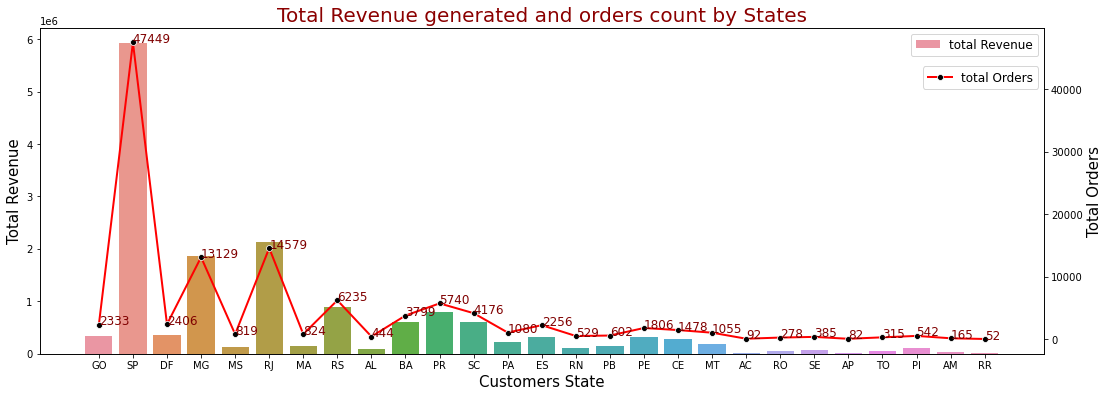

In [16]:
fig, ax1=plt.subplots(figsize=(18,6))
sns.barplot(x="customer_state",y="total_revenue",data=df,label="total Revenue", ax=ax1)
ax2=ax1.twinx()
sns.lineplot(x="customer_state",y="total_orders",data=df, ax=ax2,
             label="total Orders", color="red",linewidth="2",marker="o",markerfacecolor="k")
for x,y in zip(df["customer_state"],df["total_orders"]):
    ax2.text(x,y, f"{y}",fontsize=12,c="maroon")
ax1.set_title("Total Revenue generated and orders count by States",fontsize=20,color="darkred")
ax1.legend(loc="upper right", bbox_to_anchor=(1, 1), fontsize=12)
ax2.legend(loc="upper right", bbox_to_anchor=(1, 0.9), fontsize=12)
ax1.set_xlabel("Customers State",fontsize=15,color="k")
ax1.set_ylabel("Total Revenue",fontsize=15,color="k")
ax2.set_ylabel("Total Orders",fontsize=15,color="k")
plt.show()

## Order Count and Total Payment per Month.

In [17]:
query= """select date_format(order_purchase_timestamp, '%m/%y') as month,count(*), round(sum(payments.payment_value),2) 
        from orders join payments on orders.order_id = payments.order_id 
        group by month order by month"""
cursor.execute(query)
result=cursor.fetchall()
df=pd.DataFrame(result, columns=["Month/Year","Total_Orders","Total_payment"])
df.head()

,Month/Year,Total_Orders,Total_payment
0,01/17,850,138488.04
1,01/18,7563,1115004.18
2,02/17,1886,291908.01
3,02/18,6952,992463.34
4,03/17,2837,449863.60


## Calculate the number of orders per month in 2018.

In [18]:
query= """select monthname(order_purchase_timestamp) as month,count(order_id) from orders 
          where year(order_purchase_timestamp)="2018" group by month """
cursor.execute(query)
result=cursor.fetchall()
df=pd.DataFrame(result, columns=["Months","Total_Orders"])
df.head()

,Months,Total_Orders
0,July,6292
1,August,6512
2,February,6728
3,June,6167
4,March,7211


## Month wise payment generated for each year.

In [19]:
query= """select year(order_purchase_timestamp) as years, monthname(order_purchase_timestamp) as months,
          round(sum(payments.payment_value),2) 
        from orders join payments on orders.order_id = payments.order_id 
        group by years, months"""
cursor.execute(query)
result=cursor.fetchall()
df=pd.DataFrame(result, columns=["Years","Months","Total_payment"])
df.head()

,Years,Months,Total_payment
0,2017,September,727762.45
1,2018,August,1022425.32
2,2018,April,1160785.48
3,2018,June,1023880.50
4,2018,January,1115004.18


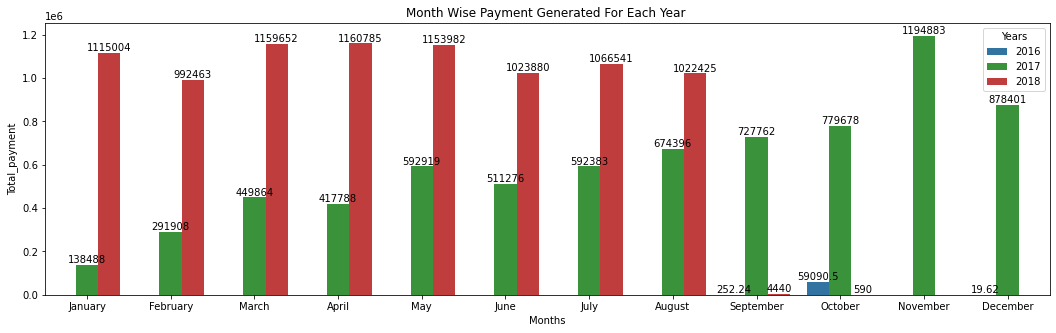

In [20]:
#import matplotlib.ticker as mticker
fig=plt.figure(figsize=(18,5))
palette = ['tab:blue', 'tab:green', 'tab:red']
order=["January","February","March","April","May","June","July","August","September","October","November","December"]
ax=sns.barplot(x="Months",y="Total_payment",data=df,estimator=sum, hue="Years",order=order,palette=palette)
ax.bar_label(ax.containers[0])
ax.bar_label(ax.containers[1], fmt="%.0f")
ax.bar_label(ax.containers[2], fmt="%.0f")
#ax.yaxis.set_major_formatter(mticker.StrMethodFormatter("{x:,.0f}"))
plt.title("Month Wise Payment Generated For Each Year ")
plt.show()

## Calculate the cumulative sales per month for each year.

In [21]:
query= """select years,monthno, months,payment,sum(payment) over(partition by years order by monthno) as comulative_sale
         from (select year(orders.order_purchase_timestamp) as years, monthname(orders.order_purchase_timestamp) as months,
          month(orders.order_purchase_timestamp) as monthno, round(sum(payments.payment_value),2) as payment 
        from orders join payments on orders.order_id = payments.order_id 
        group by years,months,monthno order by years,monthno) as t1 """
cursor.execute(query)
result=cursor.fetchall()
df=pd.DataFrame(result, columns=["Years","Month_no","Months","Sale","Comulative_Sale"])
df.head(10)

,Years,Month_no,Months,Sale,Comulative_Sale
0,2016,9,September,252.24,252.24
1,2016,10,October,59090.48,59342.72
2,2016,12,December,19.62,59362.34
3,2017,1,January,138488.04,138488.04
4,2017,2,February,291908.01,430396.05
5,2017,3,March,449863.60,880259.65
6,2017,4,April,417788.03,1298047.68
7,2017,5,May,592918.82,1890966.50
8,2017,6,June,511276.38,2402242.88
9,2017,7,July,592382.92,2994625.80


## Calculate the year-over-year growth rate of total sales.

In [22]:
query= """select years, payment,(payment-lag(payment,1) over(order by years))/lag(payment,1) over(order by years)*100 from 
         (select year(orders.order_purchase_timestamp) as years,
         round(sum(payments.payment_value),2) as payment 
        from orders join payments on orders.order_id = payments.order_id 
        group by years order by years) as t1"""
cursor.execute(query)
result=cursor.fetchall()
df=pd.DataFrame(result, columns=["Years","Sale","Sale_growth_yoy"])
df

,Years,Sale,Sale_growth_yoy
0,2016,59362.34,NaN
1,2017,7249746.73,12112.703761
2,2018,8699763.05,20.000924


## Calculate the total revenue generated by each seller, and rank them by revenue.

In [23]:
query= """with a as(select order_items.seller_id, round(sum(payments.payment_value),2) as revenue 
                    from order_items join payments on order_items.order_id=payments.order_id 
                    group by order_items.seller_id)
         select *, dense_rank() over(order by revenue desc) as rn from a"""
cursor.execute(query)
result=cursor.fetchall()
df=pd.DataFrame(result, columns=["seller_id","revenue","rank"])
df.head()

,seller_id,revenue,rank
0,7c67e1448b00f6e969d365cea6b010ab,507166.91,1
1,1025f0e2d44d7041d6cf58b6550e0bfa,308222.04,2
2,4a3ca9315b744ce9f8e9374361493884,301245.27,3
3,1f50f920176fa81dab994f9023523100,290253.42,4
4,53243585a1d6dc2643021fd1853d8905,284903.08,5


## Distribution of review score.

In [24]:
query= """select (case 
                when review_score=5 then "Very Good" 
                when review_score=4 then "Good" 
                when review_score=3 then "Average" 
                when review_score=2 then "Bad" 
                when review_score=1 then "Very Bad" end) as rating, count(review_id)
                from order_reviews group by rating
                """
cursor.execute(query)
result=cursor.fetchall()
df=pd.DataFrame(result, columns=["rating","counts"])
df

,rating,counts
0,Good,19142
1,Very Good,57328
2,Very Bad,11424
3,Average,8179
4,Bad,3151


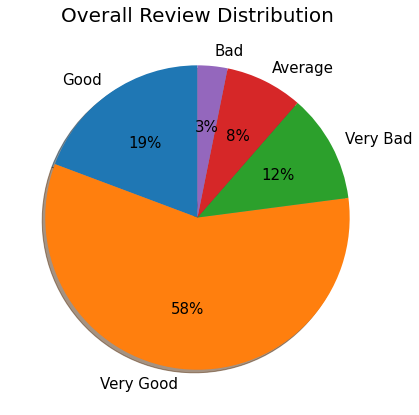

In [25]:
text={"fontsize":15,"color":"k"}
fig=plt.figure(figsize=(7,7))
plt.pie(df["counts"],labels=df["rating"],autopct="%0.00f%%",shadow=True, startangle=90,textprops=text)
plt.title("Overall Review Distribution",fontsize=20)
plt.show()

## Products with the Most Negative Reviews.

In [26]:
query= """select products.product_id, products.product_category_name, count(order_reviews.review_id) as nreview
          from products join order_items on products.product_id = order_items.product_id
          join order_reviews on order_items.order_id = order_reviews.order_id
          where order_reviews.review_score in (1, 2)
          group by products.product_id, products.product_category_name
          order by nreview desc limit 30"""
cursor.execute(query)
result=cursor.fetchall()
df=pd.DataFrame(result, columns=["product_id","product_category_name","count_of_negative_reviews"])
df.head(10)

,product_id,product_category_name,count_of_negative_reviews
0,422879e10f46682990de24d770e7f83d,ferramentas_jardim,95
1,99a4788cb24856965c36a24e339b6058,cama_mesa_banho,80
2,53759a2ecddad2bb87a079a1f1519f73,ferramentas_jardim,77
3,368c6c730842d78016ad823897a372db,ferramentas_jardim,75
4,aca2eb7d00ea1a7b8ebd4e68314663af,moveis_decoracao,74
5,389d119b48cf3043d311335e499d9c6b,ferramentas_jardim,61
6,e53e557d5a159f5aa2c5e995dfdf244b,informatica_acessorios,58
7,b532349fe46b38fbc7bb3914c1bdae07,moveis_decoracao,52
8,36f60d45225e60c7da4558b070ce4b60,informatica_acessorios,48
9,7c1bd920dbdf22470b68bde975dd3ccf,beleza_saude,45
